In [14]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from frites.conn import conn_reshape_undirected
# Import plot functions from current repo
import sys
sys.path.append('../')
from plot.plot_marsatlas import plot_marsatlas
from plot.plot_fcd import plot_fcd_circular_xr
import matplotlib.gridspec as gridspec
import pandas as pd
from ggseg import ggplot_marsatlas
import math
import matplotlib.cm as cm
from sklearn.decomposition import NMF

## Figure 2. Local spatio-temporal correlates of information gain

In [15]:
# Load GCMI data
Results_Dir = '/home/INT/brovelli.a/code/hosi_infogain/data/'
fname = Results_Dir + 'outcome_infogain_gcmi.nc'
data = xr.load_dataset(fname)

# Stats params
threshold = 0.05
title = 'Outcome Information Gain' + ' p<' + str(threshold)

# Prepare data for plotting
gcmi = data['mi']
gcmi_tval = data['tval']
pvalues = data['pv']
allroi = data.roi
nroi = len(allroi)
times = data.times

    Load MarsAtlas labels
    Consider p-values < 0.05
/home/INT/brovelli.a/code/hosi_infogain/notebooks/../plot/plot_marsatlas.py:135: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[:, ('L', 'Subcortical')] = np.nan
/home/INT/brovelli.a/code/hosi_infogain/notebooks/../plot/plot_marsatlas.py:136: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[:, ('R', 'Subcortical')] = np.nan
    Time selection between (-0.10, 1.00)


/tmp/ipykernel_4572/3939601686.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


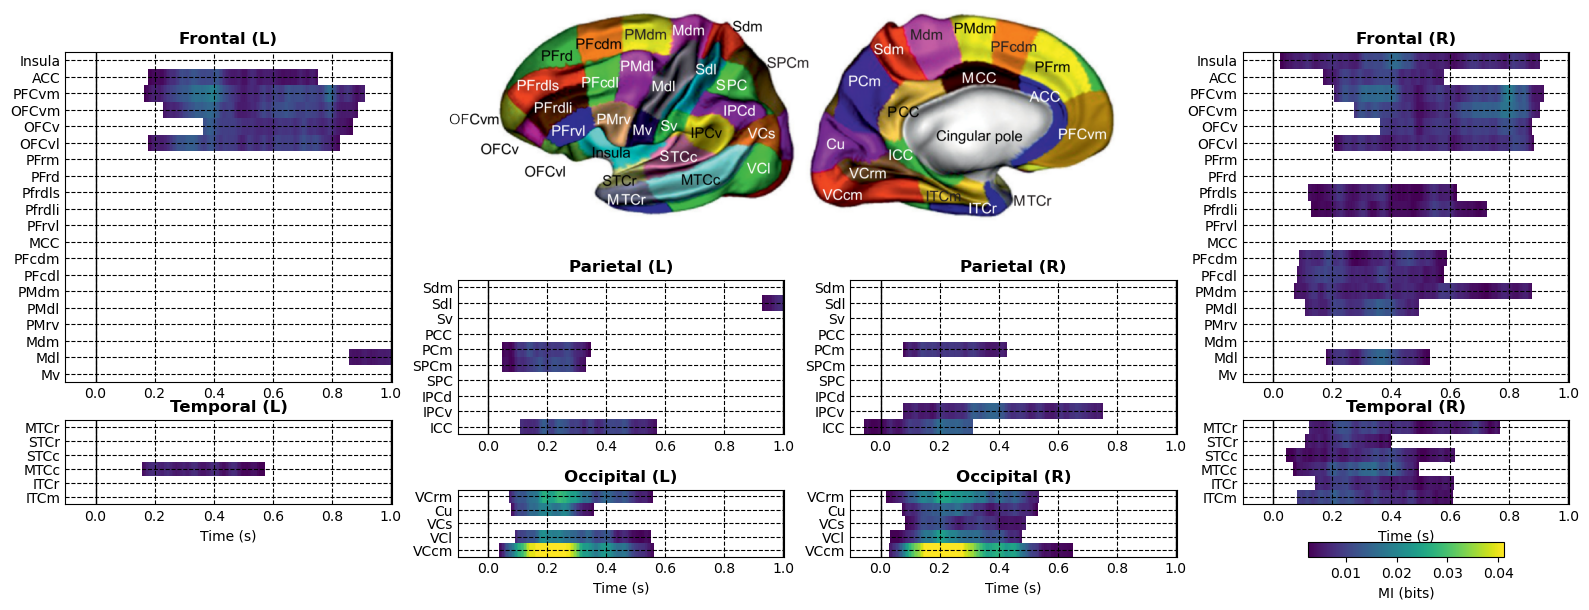

In [16]:
# Plot cluster-based gcmi on MarsAtlas
title = ''
vlines = {0.: dict(color='k', linewidth=1, linestyle='-'), 1.: dict(color='k', linewidth=1, linestyle='-')}
f = plot_marsatlas(gcmi, pvalues=pvalues, threshold=threshold, time=(-0.1, 1.),
               subcortical=False, contrast=1, cmap='viridis', title=title,
               cblabel='MI (bits)', vlines=vlines, grid=True)
# Add MarsAtlas
fname = Results_Dir + 'marsatlas.png'
marsatlas = plt.imread(fname)
newax = f.add_axes([0.29, 0.54, 0.45, 0.45])
# chage size of f to 16 x 8
f.set_size_inches(16, 6)
newax.imshow(marsatlas)
newax.axis('off')

# Adjust layout
plt.tight_layout()

plt.show()

In [17]:
# f.savefig('/home/INT/brovelli.a/Desktop/fig_visuomotor_meg/Fig_2.png', dpi=300, bbox_inches='tight')

## Figure 3. Local spatio-temporal correlates of information gain in anatomical clusters

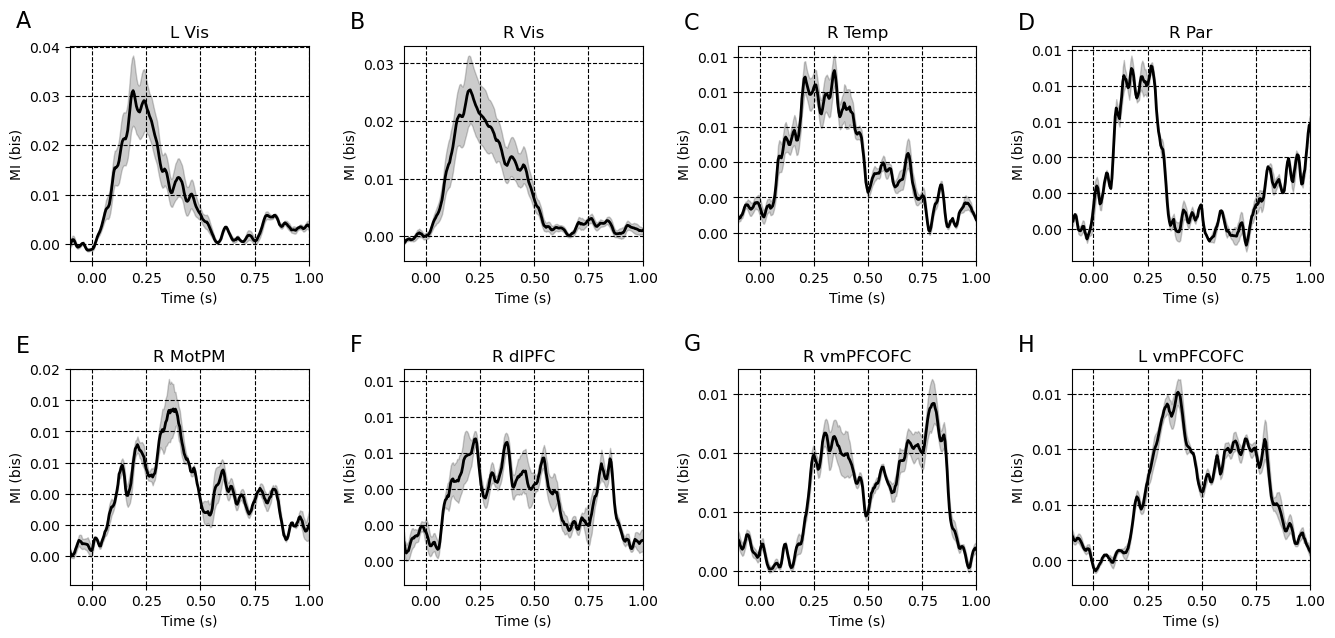

In [18]:
# Significant region of interests ROIs
visual_1 = {'vis_l': ['L_VCcm', 'L_VCl', 'L_Cu', 'L_VCrm']}
visual_2 = {'vis_r': ['R_VCcm', 'R_VCl', 'R_Cu', 'R_VCrm', 'R_VCs'] }
temporal = {'temp_r':  ['R_ITCm', 'R_ITCr', 'R_MTCc', 'R_STCc', 'R_MTCr']}
parietal = {'par_r': ['L_PCm', 'L_SPCm']}
pfc_1    = {'mot_pm_r': ['R_Mdl', 'R_PMdl', 'R_PMdm']}
pfc_2    = {'dlpfc_r': ['R_Pfrdli', 'R_Pfrdls', 'R_PFcdm', 'R_PFcdl']}
ofc_1    = {'vmpfc_ofc_r': ['R_OFCvl', 'R_OFCv', 'R_OFCvm', 'R_PFCvm']}
ofc_2    = {'vmpfc_ofc_l': ['L_OFCvl', 'L_OFCv', 'L_OFCvm', 'L_PFCvm']}


# Subplot for 2 x 4 panels
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(16, 7))

# Adjust the spacing
plt.subplots_adjust(wspace=0.4, hspace=0.5) 

# Create a function for plotting
def plot_cluster_timecourse(gcmi, roi_dict, title, panel, ax):
    # Extract ROI names from dictionary
    roi_key = list(roi_dict.keys())[0]
    roi_list = roi_dict[roi_key]
    
    # Select data for these ROIs
    Y = gcmi.sel(roi=roi_list)
    
    # Compute mean and standard error
    M = Y.mean(dim='roi')
    sem = Y.std(dim='roi') / np.sqrt(len(roi_list))
    
    # Plot the mean line
    M.plot.line(ax=ax, color='k', linewidth=2)
    
    # Plot the filled area for SEM
    ax.fill_between(gcmi.times, M - sem, M + sem, color='k', alpha=0.2)
    
    # Limit ylabel to 2 decimals
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:.2f}'.format(x)))
    # Set title, labels, and grid
    ax.set_title(title)
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('MI (bis)')
    # y lim for all plots
    ax.set_xlim([-0.1, 1.])
    ax.grid(visible=True)
    
    # Add panel text 10% on top of the maximum value
    yval = np.max(M + sem) + 0.15*np.max(M + sem)
    ax.text(-0.35, yval, panel, fontsize=16)
    
# Occipital areas (L)
plot_cluster_timecourse(gcmi, visual_1, 'L Vis', 'A', ax1)

# Occipital areas (R)
plot_cluster_timecourse(gcmi, visual_2, 'R Vis', 'B', ax2)

# Temporal areas
plot_cluster_timecourse(gcmi, temporal, 'R Temp', 'C', ax3)

# Parietal areas
plot_cluster_timecourse(gcmi, parietal, 'R Par', 'D', ax4)

# Lateral PM areas
plot_cluster_timecourse(gcmi, pfc_1, 'R MotPM', 'E', ax5)

# DLPFC areas
plot_cluster_timecourse(gcmi, pfc_2, 'R dlPFC', 'F', ax6)

# VMPFC/OFC areas (R)
plot_cluster_timecourse(gcmi, ofc_1, 'R vmPFCOFC', 'G', ax7)

# VMPFC/OFC areas (L)
plot_cluster_timecourse(gcmi, ofc_2, 'L vmPFCOFC', 'H', ax8)


## Figure 4. NMF of GMCI time courses

In [19]:
#-----------------------------------------------------------------------------------------------------------------------
# NMF
#----------------------------------------------------------------------node_colors-------------------------------------------------
da_gcmi = np.abs(gcmi) * (pvalues < 0.05)
da_gcmi = da_gcmi.sel(times=slice(-0.1, 1.0))
nmax = 10
err = np.zeros(nmax+1)
for n in range(1, nmax+1):
    nmf = NMF(n_components=n, init='random', random_state=0)
    X = da_gcmi.data
    Y = nmf.fit_transform(X)
    err[n] = nmf.reconstruction_err_

# Compute explained variance in percentage
err = err / np.sum(err)

# Compute components
nmax = 4
nmf = NMF(n_components=nmax, init='random', random_state=0)
X = da_gcmi
W = nmf.fit_transform(X)
H = nmf.components_

/home/INT/brovelli.a/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/INT/brovelli.a/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/INT/brovelli.a/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/INT/brovelli.a/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/INT/brovelli.a/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Inc

In [20]:
# Significant region of interests ROIs dataset
rois = {
        'L Vis': ['L_VCcm', 'L_VCl', 'L_Cu', 'L_VCrm'],
        'R Vis': ['R_VCcm', 'R_VCl', 'R_Cu', 'R_VCrm', 'R_VCs'],
        'R Temp':  ['R_ITCm', 'R_ITCr', 'R_MTCc', 'R_STCc', 'R_MTCr'], 
        'L Par': ['L_PCm', 'L_SPCm'] ,
        'R MotPM': ['R_Mdl', 'R_PMdl', 'R_PMdm'],
        'R dlPFC': ['R_Pfrdli', 'R_Pfrdls', 'R_PFcdm', 'R_PFcdl'],
        'L vmPFCOFC': ['L_OFCvl', 'L_OFCv', 'L_OFCvm', 'L_PFCvm'],
        'R vmPFCOFC': ['R_OFCvl', 'R_OFCv', 'R_OFCvm', 'R_PFCvm'],
}


# Try to plot barh plot
data = H
data = data / data.sum(axis=0)

da = xr.DataArray(
    data=data,
    dims=["loadings", "rois"],
    coords=dict(
        loadings=[1, 2, 3, 4],
        rois=allroi.data
    ),
)

areas = list(rois.keys())

p = np.zeros((8, 4))
i = 0
for roi in rois:
    Y = da.sel(rois=rois[roi])
    Y = Y.mean(dim='rois')
    p[i] = Y.data
    i += 1


perc = xr.DataArray(
    data=p,
    dims=["areas", "loadings"],
    coords=dict(
        loadings=[1, 2, 3, 4],
        areas=list(rois.keys())
    ),
)

perc = perc / perc.sum(axis=1) * 100
data = perc.data
data_cum = perc.cumsum(axis=1).data

/tmp/ipykernel_4572/2345353188.py:16: RuntimeWarning: invalid value encountered in divide
  data = data / data.sum(axis=0)


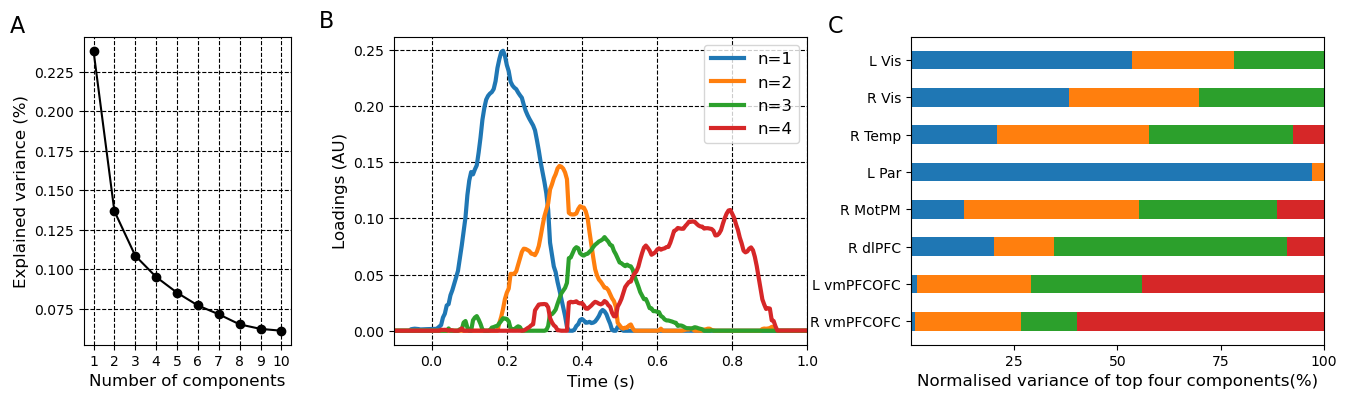

In [21]:
import matplotlib as mpl
category_colors = mpl.cm.RdYlGn(np.linspace(0.15, 0.85, 4))
category_colors = ['C0', 'C1', 'C2', 'C3']


category_names = ['n=1', 'n=2',
                  'n=3', 'n=4']

# Subplot per area
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 2, 2]})
# Adjust the spacing so that the third panel is move a bit to the right
plt.subplots_adjust(wspace=0.3)


# Plot variance explained in ax1
ax1.plot(range(1, 11), err[1:11],'ko-')
ax1.set_xlabel('Number of components', fontsize=12)
ax1.set_ylabel('Explained variance (%)', fontsize=12)
# Add xtick every 1
ax1.set_xticks(range(1, 11))
# add grid
ax1.grid()
ax1.text(-3., 0.25, 'A', fontsize=16)

# Plot loadings
for n in range(nmax):
    ax2.plot(da_gcmi.times, W[:,n], label=f"n={n+1}", linewidth=3)
ax2.set_xlim([-0.1, 1])
ax2.set_xlabel('Time (s)', fontsize=12)
ax2.grid(True)
ax2.text(-0.3, 0.27, 'B', fontsize=16)
# Add ylabels
ax2.set_ylabel('Loadings (AU)', fontsize=12)
# Add legend
ax2.legend(loc='upper right', fontsize=12)


ax3.invert_yaxis()
ax3.xaxis.set_visible(True)
ax3.set_xlim(0, np.sum(data, axis=1).max())
for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    # Put labels on the right
    rects = ax3.barh(areas, widths, left=starts, height=0.5,
                     color=color)
    # 


    # r, g, b, _ = color
    # text_color = 'white' if r * g * b < 0.5 else 'darkgrey'

    # ax.bar_label(rects, label_type='center', color=text_color)
    
# ax.legend(ncol=4, bbox_to_anchor=(0, 1),
#               loc='lower left', fontsize='small')

ax3.set_xticks(np.arange(25, 101, 25))
ax3.set_xticklabels(np.arange(25, 101, 25))
ax3.set_xlabel('Normalised variance of top four components(%)', fontsize=12)
ax3.text(-20, -0.75, 'C', fontsize=16)

plt.show()


## Figure 5. Redundancy and Synergy links encoding Information Gain

In [22]:
# Load data
fname = Results_Dir + 'outcome_infogain_pairwise_redundancy.nc'
ds = xr.load_dataset(fname)
# Thresholded data
da = ds.fredc * (ds.pv <= 0.05)
# Rename dim links
da = da.rename({'links': 'roi'})
# Select time interval
da = da.sel(times=slice(-0.1, 1.))
# Red 
red = da
# Load data
fname = Results_Dir + 'outcome_infogain_pairwise_synergy.nc'
ds = xr.load_dataset(fname)
# Thresholded data
da = ds.fsync * (ds.pv <= 0.05)
# Rename dim links
da = da.rename({'links': 'roi'})
# Select time interval
da = da.sel(times=slice(-0.1, 1.))
# Syn 
syn = da
# Take abs to remove potential -ve values due to bias correction
red = np.abs(red)
syn = np.abs(syn)

In [23]:
# Store for later
red_conn = conn_reshape_undirected(red, sep='-', order=None, rm_missing=False,
                                 fill_value=np.nan, to_dataframe=False,
                                 inplace=False, verbose=None)
syn_conn = conn_reshape_undirected(syn, sep='-', order=None, rm_missing=False,
                                 fill_value=np.nan, to_dataframe=False,
                                 inplace=False, verbose=None)

/home/INT/brovelli.a/anaconda3/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/INT/brovelli.a/anaconda3/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


/home/INT/brovelli.a/anaconda3/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/INT/brovelli.a/anaconda3/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/INT/brovelli.a/anaconda3/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/home/INT/brovelli.a/anaconda3/lib/python3.9/site-packages/xarray/core/concat.py:527: Futur

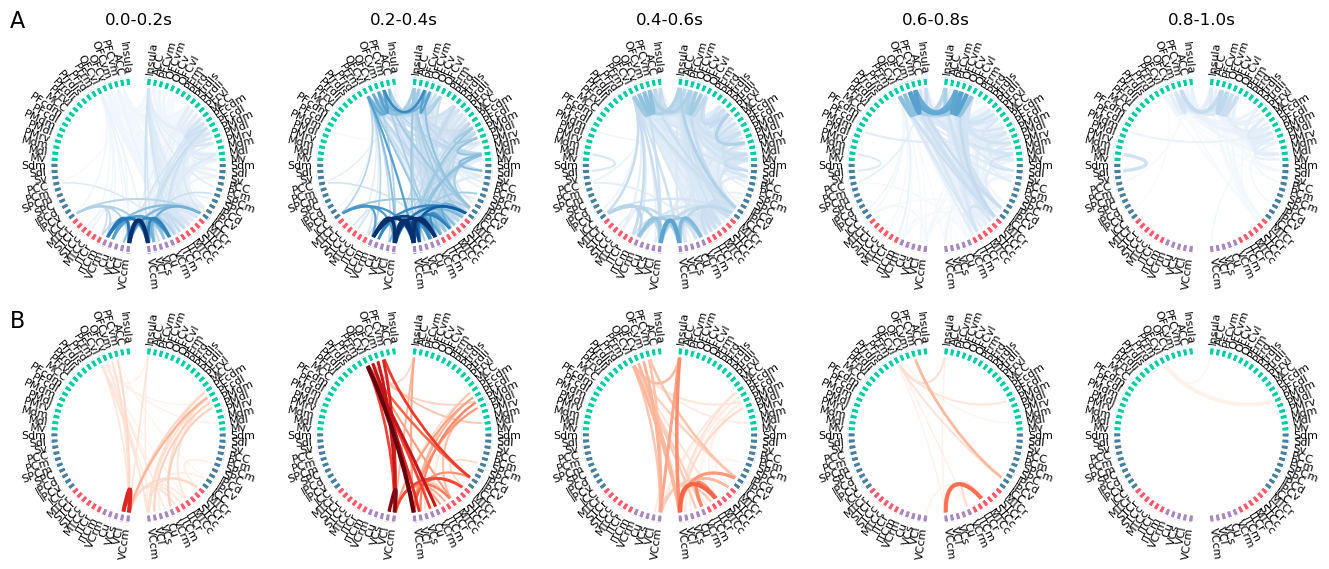

In [49]:
# Subplot per area
f, axs = plt.subplots(2, 5, figsize=(16, 6))
axs = np.ravel(axs)
# Add space horizontally between subplots
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.4)

# Time intervals
dt = 0.2
tc = np.arange(0.1, 0.95, 0.2)

i = 0
for t in tc:
    # Select time interval
    da = red.sel(times=slice(t-dt/2, t+dt/2))
    # Avergage over time
    da = da.mean(dim='times')
    # Create adj conn matrix
    da = conn_reshape_undirected(da, sep='-', order=None, rm_missing=False,
                                 fill_value=np.nan, to_dataframe=False,
                                 inplace=False, verbose=None)
    # Squeeze time axis
    da = da.squeeze()

    # Plot circular
    # plt.sca(axs[i])
    subplot_title = str(np.round((t-dt/2)*100)/100) + '-' + str(np.round((t+dt/2)*100)/100) + 's'

    plot_fcd_circular_xr(da.where(da > 0.), node_color='lobe', colorbar=False, vmax=0.015, cmap='Blues',
                         cmap_node='Blues', lobes=['Frontal', 'Parietal', 'Occipital', 'Temporal'],
                         fig=f, subplot=(2,5,i+1), title=subplot_title)
   
    # Reduce the font of the title
    plt.title(subplot_title, fontsize=12, fontweight='bold')
    # move the title up a bit
    plt.title(subplot_title, y=1.25)
    
    i += 1

for t in tc:

    # Select time interval
    # da = red.sel(times=slice(start, start + dt))
    da = syn.sel(times=slice(t-dt/2, t+dt/2))

    # Avergage over time
    da = da.mean(dim='times')

    # Create adj conn matrix
    da = conn_reshape_undirected(da, sep='-', order=None, rm_missing=False,
                                 fill_value=np.nan, to_dataframe=False,
                                 inplace=False, verbose=None)
                             
    # Squeeze time axis
    da = da.squeeze()

    # Plot abs values
    da = np.abs(da)

    plot_fcd_circular_xr(da.where(da > 0.), node_color='lobe', vmax=0.006, colorbar=False, cmap='Reds',
                        cmap_node='Reds', lobes=['Frontal', 'Parietal', 'Occipital', 'Temporal'],
                        fig=f, subplot=(2,5,i+1))

    
    i += 1

# Add text to the top row of subplots
plt.text(0.1, 0.95, 'A', fontsize=16, transform=plt.gcf().transFigure)
plt.text(0.1, 0.45, 'B', fontsize=16, transform=plt.gcf().transFigure)

plt.show()


In [25]:
# f.savefig('/home/INT/brovelli.a/Desktop/fig_visuomotor_meg/Fig_5.png', dpi=300, bbox_inches='tight')

## Figure 6. Within and across redundancy and synergy

In [26]:
# Significant region of interests ROIs
rois = {
        'Visual': ['L_VCcm', 'L_VCl', 'L_Cu', 'L_VCrm', 'R_VCcm', 'R_VCl', 'R_Cu', 'R_VCrm', 'R_VCs'],
        'Temporal': ['R_ITCm', 'R_ITCr', 'R_MTCc', 'R_STCc', 'R_MTCr'], 
        'Mot/PM': ['R_Mdl', 'R_PMdl', 'R_PMdm'],
        'dlPFC': ['R_Pfrdli', 'R_Pfrdls', 'R_PFcdm', 'R_PFcdl'],
        'vmPFC/OFC': ['L_OFCvl', 'L_OFCv', 'L_OFCvm', 'L_PFCvm', 'R_OFCvl', 'R_OFCv', 'R_OFCvm', 'R_PFCvm']
}

# Subplot per area
# fig, axs = plt.subplots(5, 5, figsize=(24, 24))

# red_conn = np.abs(red_conn)
# syn_conn = np.abs(syn_conn)

col = ['C0', 'C3']
# Init
red_within = []
red_across = []
syn_within = []
syn_across = []
i = 0
for xroi in rois:

        for yroi in list(rois)[i::]:

                # Select links for 
                x = red_conn.sel(sources=rois[xroi], targets=rois[yroi])
                # Avergage over links
                x = x.mean(dim=['sources', 'targets'])                        
                #         Squeeze time axis
                x = x.squeeze()

                # Select links for 
                y = syn_conn.sel(sources=rois[xroi], targets=rois[yroi])
                # Avergage over links
                y = y.mean(dim=['sources', 'targets'])                        
                # Squeeze time axis
                y = y.squeeze()

                # Concat
                xy = np.transpose([x.values, y.values])
                # xy = y.values
                times = da_gcmi.times
                
                # axs[i, j].plot(times, xy)

                # # axs[i, j].set_title('Occipital')
                # axs[i, j].set_xlim((-0.1, 1))
                # axs[i, j].set_title(xroi + '-' + yroi)

                # Red and Syn for within and across links
                if xroi == yroi :
                        red_within += [x.values]
                else:
                        red_across += [x.values]

                if xroi == yroi :
                        syn_within += [y.values]
                else:
                        syn_across += [y.values]


        i += 1

Text(-0.3, 0.0003, 'B')

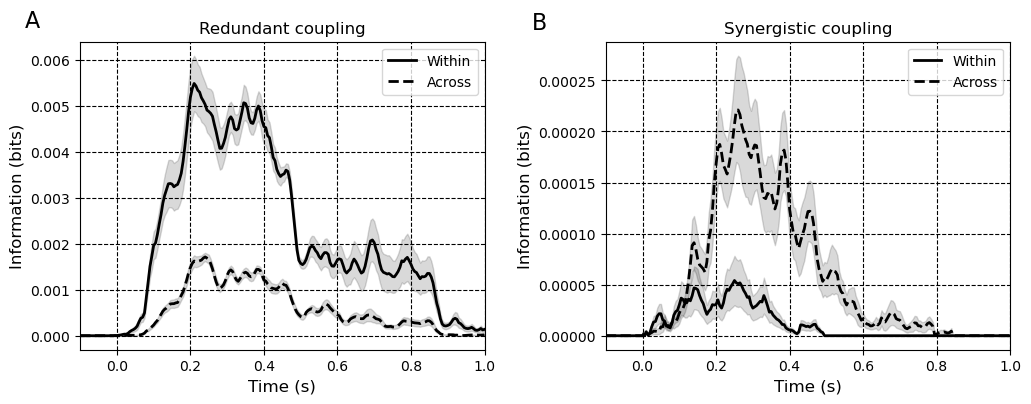

In [44]:
# Subplot per area

f, axs = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(wspace=0.3)

# Red
m1 = np.mean(red_within, axis=0)
sem1 = np.std(red_within, axis=0)/np.sqrt(np.shape(red_within)[0])/2
axs[0].plot(times, m1, linewidth=2, linestyle='-', color='black')

m2 = np.mean(red_across, axis=0)
sem2 = np.std(red_across, axis=0)/np.sqrt(np.shape(red_across)[0])/2
axs[0].plot(times, m2, linewidth=2, linestyle='--', color='black')

# Add legend for blue and orange curves without the shaded areas
axs[0].legend(['Within', 'Across'])

# Add shaded areas
axs[0].fill_between(times, m1 - sem1, m1 + sem1 , alpha=0.15, color='black')
axs[0].fill_between(times, m2 - sem2, m2 + sem2 , alpha=0.15, color='black')

axs[0].set_title('Redundant coupling')
axs[0].set_xlabel('Time (s)', fontsize=12)
# y-label
axs[0].set_ylabel('Information (bits)', fontsize=12)
axs[0].set_xlim((-0.1, 1.))
axs[0].grid(True)
axs[0].text(-0.25, 0.0067, 'A', fontsize=16)

# Syn
m1 = np.mean(syn_within, axis=0)
sem1 = np.std(syn_within, axis=0)/np.sqrt(np.shape(syn_within)[0])/2
axs[1].plot(times, m1, linewidth=2, linestyle='-', color='black')

m2 = np.mean(syn_across, axis=0)
sem2 = np.std(syn_across, axis=0)/np.sqrt(np.shape(syn_within)[0])/2
axs[1].plot(times, m2, linewidth=2, linestyle='--', color='black')

# Add legend for blue and orange curves without the shaded areas
axs[1].legend(['Within', 'Across'])

# Add shaded areas
axs[1].fill_between(times, m1 - sem1, m1 + sem1 , alpha=0.15, color='black')
axs[1].fill_between(times, m2 - sem2, m2 + sem2 , alpha=0.15, color='black')


axs[1].set_title('Synergistic coupling')
axs[1].set_xlabel('Time (s)', fontsize=12)
# Set linetype
# y-label
axs[1].set_ylabel('Information (bits)', fontsize=12)
axs[1].set_xlim((-0.1, 1.))
axs[1].grid(True)
axs[1].text(-0.3, 0.0003, 'B', fontsize=16)

## Figure 7. Higher-order synergy with Bayesian surprise

In [28]:
# Load data
fname = Results_Dir + 'outcome_infogain_cluster_hoi_synergy.nc'
ds = xr.load_dataset(fname)

# Thresholded data
# data_mi = ds.hoi  * (ds.pv <= 0.05)
data = ds.tv * (ds.pv <= 0.05)
data_sign = ds.tv  * (ds.pv <= 0.05)

# Select time interval
data = data.sel(times=slice(-0.1, 1.))

# Select link with non zero entries in the matrix
data = data.sel(links=data_sign.links[data_sign.sum('times') != 0])

# Calculate the order of each link (multiplet)
# (i.e. the number of '-' in the label of the two nodes of the link)
labels = data['links']
order = [len([c for c in s if c == '-']) for s in labels.values]
# adde 1 to the order to avoid 0
order = np.array(order) + 1
order = np.array(order)
# add dimension with tplt.subplots_adjust(wspace=0.3)he valuers of order to the dataframe
data['order'] = ('links', order)

# Tranform to dataframe
data = data.T
df = data.to_pandas()

/tmp/ipykernel_4572/2617823999.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontweight='normal', fontsize=10)
/tmp/ipykernel_4572/2617823999.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([i.replace('_', ' ') for i in df.index])


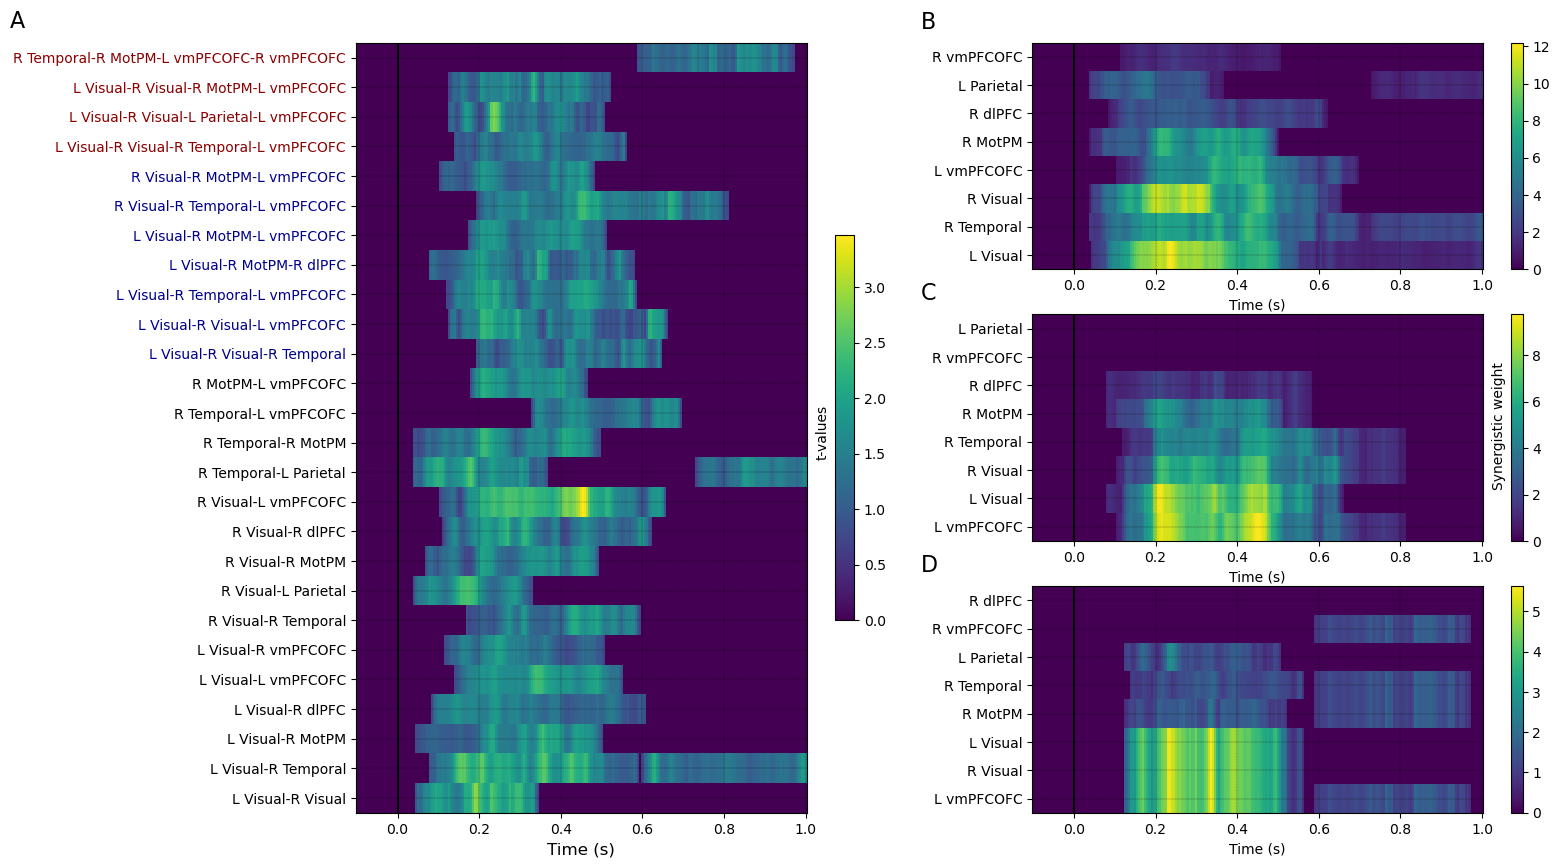

In [29]:
# Plot figure with subplots of different sizes
fig = plt.figure(1, figsize=(16, 10))
# Use gridspec to partition the figure into subplots
gridspec.GridSpec(3,2)
# Get axes object
ax = plt.subplot2grid((3,2), (0,0), rowspan=3, colspan=1)
# Plot heatmap
plt.pcolormesh(
    df.columns, df.index, data.values, cmap='viridis', shading='auto',
)
plt.xlabel('Time (s)', fontsize=12)
# set xtick label fontsize to 8
plt.xticks(fontsize=10)
plt.axvline(0., color='k')

# Set the color of the ylabel to red for the first 10 labels
for i, t in enumerate(ax.get_yticklabels()):
    if order[i] == 2:
        t.set_color('k')
    elif order[i] == 3:
        t.set_color('darkblue')
    else :
        t.set_color('darkred')


# Set the ylabels font to bold 
ax.set_yticklabels(ax.get_yticklabels(), fontweight='normal', fontsize=10)
# legend
plt.colorbar(shrink=0.5)
# Reduce the width of the colorbar
# Add the legend of the colorbar
plt.text(1.025, 11.5, 't-values', fontsize=10, rotation=90)
# cbar.ax.set_position([-.2, -0.05, .01, .6])
# Set the label of the colorbar on top of the colorbar

# remove underscores from ylabels 
ax.set_yticklabels([i.replace('_', ' ') for i in df.index])
# add grid dotted
plt.grid(True, linestyle='--', linewidth=0.2)

# Add subplot label
ax.text(-0.95, 26, 'A', fontsize=16)

#-----------------------------------------------
# Analysis of temporal hypergraph representation
#-----------------------------------------------
# ROI labels
list_rois = ['L_Visual', 'R_Visual', 'L_Parietal', 'R_Temporal', 'R_MotPM', 'R_dlPFC' , 'L_vmPFCOFC','R_vmPFCOFC']
# Short ROIS labels
list_rois_short = ['L Vis', 'R Vis', 'L Par', 'R Temp', 'R MotPM', 'R dlPFC' , 'L vmOFC','R vmOFC']
# Titles
titles = ['Pairs', 'Triplets', 'Quadruplets']
subplot_label = ['B', 'C', 'D']
# Get only a specific order of the edges hypergraph
# Node weights as array of shape (n_orders, n_rois)
node_weights = np.zeros((3, len(list_rois)))
# Loop over orders
for k, o in enumerate(np.unique(order)):
    # Find the indices of the edges at a specific order
    ind_order = np.where(data.links.order == o)[0]
    # Select the data at a specific order
    data_order = data[ind_order]
    # Define roi weight vector for all time points
    weights = np.zeros((len(list_rois), data_order.shape[1]))
    # Loop over time points
    for t in range(data_order.shape[1]):
        # Get the indices of the edges that are active at time t
        ind = np.where(data_order.values[:, t] > 0)[0]
        # Get the labels of the active hyperedges
        labels = data_order.links[ind]
        for j, s in enumerate(labels.links.data):
            # Find the indices of the edges that contain the ROI
            ind_roi = [i for i, roi in enumerate(list_rois) if roi in s]
            # Get the weights of the active hyperedges
            weights[ind_roi, t] = weights[ind_roi, t] + data_order.values[ind[j], t]

    # Store normalised node weights for each order for later plots
    node_weights[k] = weights.sum(axis=1) / weights.sum()
    # Get axes object
    ax = plt.subplot2grid((3,2), (k, 1), rowspan=1, colspan=1)
    # Sort weights by values
    ind_sort = np.argsort(weights.sum(axis=1))
    # Select data
    weights = weights[ind_sort, :]
    # plot the weights with pcolormesh
    plt.pcolormesh(data_order.times, range(len(list_rois)), weights, shading='auto')
    # add xlabel only the last subplot
    plt.xlabel('Time (s)', fontsize=10)
    # make colormap
    plt.set_cmap('viridis')
    # Fontsize of the colorbar
    plt.colorbar().ax.tick_params(labelsize=10)
    # set xtick label fontsize to 8
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    # Add yticks only the first subplot
    # remove "_" from yticklabels
    list_rois_ = [i.replace('_', ' ') for i in list_rois]
    # Sort list_rois_ according to ind_sort
    list_rois_ = [list_rois_[i] for i in ind_sort]
    # Replace list_rois_ with list_rois_short
    # list_rois_ = list_rois_short
    plt.yticks(range(len(list_rois_)), list_rois_, fontsize=10)
    # invert order of yticklabels
    plt.gca().invert_yaxis()
    # add zero line
    plt.axvline(0., color='k')
    # Add text vertically to the left of the subplot
    # plt.ylabel(titles[k], fontsize=12, rotation=90, labelpad=8)
    # add dotted grid
    plt.grid(True, linestyle='--', linewidth=0.2)

    # Add subplot label that changes with the order
    ax.text(-0.375, -1, subplot_label[k], fontsize=16)

# Add the legend of the colorbar
plt.text(1.025, -4., 'Synergistic weight', fontsize=10, rotation=90)

# Create data frame of node weigghts
df_node_weights = pd.DataFrame(node_weights, columns=list_rois_short, index=titles)

In [30]:
# Compute the number of significant links at order 2
order = data.links.order
order_2 = np.where(order == 2)[0]
order_3 = np.where(order == 3)[0]
order_4 = np.where(order == 4)[0]
order_5 = np.where(order == 5)[0]
# Number of links pairwise from 8 nodes
nlinks = math.comb(8, 2)
# Number of triplets from 8 nodes
ntriplets = math.comb(8, 3)
# Number of quadruplets from 8 nodes
nquadruplets = math.comb(8, 4)
# NUmber of quintuplets from 8 nodes
nquintuplets = math.comb(8, 5)

# print the percentage of significant links at all orders
print('Percentage of significant links at order 2: {0:.2f}%'.format(100 * len(order_2) / nlinks))
print('Percentage of significant links at order 3: {0:.2f}%'.format(100 * len(order_3) / ntriplets))
print('Percentage of significant links at order 4: {0:.2f}%'.format(100 * len(order_4) / nquadruplets))
print('Percentage of significant links at order 5: {0:.2f}%'.format(100 * len(order_5) / nquintuplets))
# print the numer of significant links at all orders
print('Number of significant links at order 2: {0}'.format(len(order_2)))
print('Number of significant links at order 3: {0}'.format(len(order_3)))
print('Number of significant links at order 4: {0}'.format(len(order_4)))   
print('Number of significant links at order 5: {0}'.format(len(order_5)))

Percentage of significant links at order 2: 53.57%
Percentage of significant links at order 3: 12.50%
Percentage of significant links at order 4: 5.71%
Percentage of significant links at order 5: 0.00%
Number of significant links at order 2: 15
Number of significant links at order 3: 7
Number of significant links at order 4: 4
Number of significant links at order 5: 0


In [31]:
fig.savefig('/home/INT/brovelli.a/Desktop/fig_visuomotor_meg/Fig_6.png', dpi=300, bbox_inches='tight')

## Figure 7. Feature-specfic Information Transfer encoding Bayesian surprise


Text(1.015, 1, 'FIT (bits)')

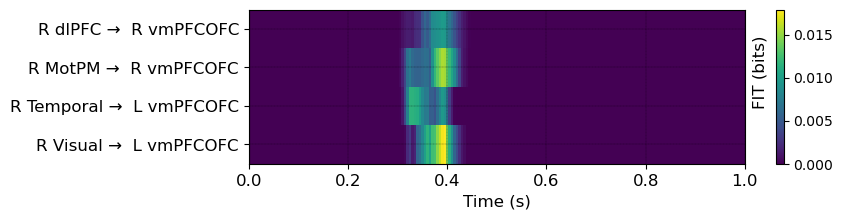

In [32]:
fname = Results_Dir + 'outcome_infogain_cluster_FIT.nc'
ds = xr.load_dataset(fname)

# Create thresholded FC matrix
da = ds.fit * (ds.pv <= 0.05)

# Rename dim links
# da = da.rename({'links': 'roi'})

# Select time interval
da = da.sel(times=slice(-0.1, 1.))

# Plot heatmap of the pairs of brain regions showing significant values different from 0
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
# Select the links with non zero values
da = da.sel(links=da.links[da.sum('times') != 0])
plt.pcolormesh(
    da.times, da.links, da.T, cmap='viridis', shading='auto',
)
# Add colorbar
plt.colorbar()
# Set xlim to -0.1 to 1.0   
plt.xlim(0., 1.0)

# add zero line
plt.axvline(0., color='k')
# Add text vertically to the left of the subplot
# plt.ylabel(titles[k], fontsize=12, rotation=90, labelpad=8)
# add dotted grid
plt.grid(True, linestyle='--', linewidth=0.2)


# Replace "->" with an arrow symbol
labels = da.links.values
labels = [i.replace('->', ' →  ') for i in labels]
# remove "_" from yticklabels
labels = [i.replace('_', ' ') for i in labels]
# Set the yticklabels
plt.yticks(range(len(labels)), labels, fontsize=12)
# Set the xticklabels
plt.xticks(fontsize=12)
# Add xlabel
plt.xlabel('Time (s)', fontsize=12)
# Add the legend of the colorbar

# Add the legend of the colorbar
plt.text(1.015, 1, 'FIT (bits)', fontsize=12, rotation=90)

# # Set colorscale from 0 to 1.5
# plt.clim(0, 1.2)


In [33]:
fig.savefig('/home/INT/brovelli.a/Desktop/fig_visuomotor_meg/Fig_8.png', dpi=300, bbox_inches='tight')